# 作业2: 频繁模式与关联规则挖掘

322010840 刘聪聪

仓库地址 https://github.com/liucc1997/DMC/tree/master/assignment2

## 1.问题描述
选择1个数据集进行频繁模式和关联规则挖掘。

数据分析要求
- 对数据集进行处理，转换成适合进行关联规则挖掘的形式；
- 找出频繁模式；
- 导出关联规则，计算其支持度和置信度;
- 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种；
- 对挖掘结果进行分析；
- 可视化展示

### 数据集

wine-reviews

一共2个csv文件

- winemag-data_first150k.csv

包含10列和15万条葡萄酒评论

- winemag-data_first150k.csv

包含10列和13万行葡萄酒评论

这里我们首先分析winemag-data_first150k.csv文件的情况，数据属性如下列出：

- country 国家 
- desprition 描述
- designation 葡萄酒庄
- pints 得分
- price 价格
- province 省份
- region_1 区域1
- region_2 区域2
- variety 葡萄种类
- winery 酿酒厂

## 2.数据处理

首先导入数据集合

In [262]:
import matplotlib
import numpy as np
import pandas as pd
%matplotlib inline
path_15k = "../data/wine-reviews/winemag-data_first150k.csv"
data_15k = pd.read_csv(path_15k)

首先需要对数据集中的不同的属性进行处理

1. 数据集中第一个属性未命名，是评论的序号，是唯一的，desprition属性是对于葡萄酒的自然语言描述，也是唯一值，二者在分析过程中不做考虑。

2. country、province、region_1和region_2是对葡萄酒产地的位置信息，出于分析复杂性和这四个属性的数据缺失情况考虑，这四个属性中只选择country进行挖掘。country属性中存在3个缺失值，所以需要通过属性的相关关系来填补缺失值，使用designation的属性来判断所属国家。

In [263]:
#根据空值的分布，定义一个从designation到country的转换字典
designation2country = {
    "Askitikos":"Greece",    
    "Shah":"US",
    "Piedra Feliz":"Chile",
}
#处理country的空值
def country_nan_hander(data):
    for i in range(0,len(data)):
        tmp = data.iloc[i,1]
        if pd.isnull(tmp):
            designation = data.iloc[i,3]
            data.iloc[i,1] = designation2country[designation]
    return data


3. price、points是数值属性，对price进行离散化处理，此外points和price属性需要加上前缀，方便区分频繁项生成结果。


In [264]:
def points_discretization(value):
    return "points-"+str(int(value/5))

def price_discretization(value):
    if value < 100:
        return "price-"+str(int(value/10))
    else:
        return "price-10"

最后选取的属性包括designation、country、price、points，在之后的找出频繁模式调用mlxtend库来实现，因此还需要将数据处理成相应的格式。

In [265]:
data_15k = pd.read_csv(path_15k)

#处理country的空值
country_nan_hander(data_15k)

#过滤属性
data_15k = data_15k.drop(['Unnamed: 0','description','province','region_1','region_2','variety','winery','designation'],axis = 1)
#data_15k['country'].value_counts(dropna = False)

In [266]:
#离散化处理
data_15k.loc[:,'points'] = data_15k['points'].map(lambda x:points_discretization(x))
data_15k.loc[:,'price'] = data_15k['price'].map(lambda x:price_discretization(x))

In [267]:
#dataframe转换为列表
def deal(data):
    return data.to_list()
data_15k_arr = data_15k.apply(deal,axis=1).tolist()

In [268]:
#TransactionEncoder转换
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
tf = te.fit_transform(data_15k_arr)
new_df = pd.DataFrame(tf,columns=te.columns_)

## 3.频繁模式

然后调用mlxtend中的apriori函数寻找频繁模式，最小支持度阈值取0.03

In [269]:
from mlxtend.frequent_patterns import apriori
result = apriori(new_df, min_support=0.03, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	


In [270]:
print(result.shape)
result[:20]

(52, 2)


,support,itemsets
9,0.526887,(points-17)
7,0.413423,(US)
12,0.303419,(price-1)
10,0.299669,(points-18)
14,0.212986,(price-2)
37,0.201034,"(price-1, points-17)"
29,0.199788,"(points-17, US)"
4,0.155556,(Italy)
8,0.153694,(points-16)
3,0.139787,(France)


## 4.关联规则

然后从频繁项集中导出关联规则，并计算其支持度和置信度。这里使用mlxtend包中的association_rules方法，支持度阈值为0.03，置信度阈值设为0.4，方法默认状态下会计算关联规则的计算支持度、置信度和提升度。

In [271]:
from mlxtend.frequent_patterns import association_rules	
rules =  association_rules(result,metric ='confidence',min_threshold = 0.4)
rules = rules.drop(['leverage','conviction'],axis = 1)
print(rules.shape)
rules

(28, 7)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(price-1),(points-17),0.303419,0.526887,0.201034,0.662561,1.257503
1,(US),(points-17),0.413423,0.526887,0.199788,0.483253,0.917185
2,(price-2),(points-17),0.212986,0.526887,0.131604,0.617900,1.172737
3,(points-18),(US),0.299669,0.413423,0.128748,0.429636,1.039215
4,(price-2),(US),0.212986,0.413423,0.106460,0.499844,1.209038
5,(Italy),(points-17),0.155556,0.526887,0.093964,0.604055,1.146461
6,(points-16),(price-1),0.153694,0.303419,0.079454,0.516963,1.703795
7,(price-3),(US),0.124554,0.413423,0.076784,0.616469,1.491132
8,(points-16),(US),0.153694,0.413423,0.076048,0.494805,1.196849
9,(France),(points-17),0.139787,0.526887,0.066998,0.479287,0.909659


如下列出导出的各项关联规则：

In [272]:
for index, row in rules.iterrows():
    #print(row)
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%s ⇒ %s (suupport = %f, confidence = %f )"%(t1,t2,row['support'],row['confidence']))

('price-1',) ⇒ ('points-17',) (suupport = 0.201034, confidence = 0.662561 )
('US',) ⇒ ('points-17',) (suupport = 0.199788, confidence = 0.483253 )
('price-2',) ⇒ ('points-17',) (suupport = 0.131604, confidence = 0.617900 )
('points-18',) ⇒ ('US',) (suupport = 0.128748, confidence = 0.429636 )
('price-2',) ⇒ ('US',) (suupport = 0.106460, confidence = 0.499844 )
('Italy',) ⇒ ('points-17',) (suupport = 0.093964, confidence = 0.604055 )
('points-16',) ⇒ ('price-1',) (suupport = 0.079454, confidence = 0.516963 )
('price-3',) ⇒ ('US',) (suupport = 0.076784, confidence = 0.616469 )
('points-16',) ⇒ ('US',) (suupport = 0.076048, confidence = 0.494805 )
('France',) ⇒ ('points-17',) (suupport = 0.066998, confidence = 0.479287 )
('price-3',) ⇒ ('points-17',) (suupport = 0.062327, confidence = 0.500399 )
('price-2', 'points-17') ⇒ ('US',) (suupport = 0.060757, confidence = 0.461662 )
('price-2', 'US') ⇒ ('points-17',) (suupport = 0.060757, confidence = 0.570700 )
('price-1', 'US') ⇒ ('points-17',)

## 5.规则评价

然后对规则进行评价，这里使用提升度Lift和全置信度allconf。提升度Lift已经在 4.导出关联规则 的过程中被计算出来了，如下计算全置信度。

In [273]:
def allconf(x):
    return x.support/max(x['antecedent support'],x['consequent support'])
allconf_list = []
for index, row in rules.iterrows():
    allconf_list.append(allconf(row))
rules['allconf'] = allconf_list
rules.drop(['antecedent support','consequent support'],axis=1,inplace=False)#.sort_values(by=['lift'], ascending=False)

,antecedents,consequents,support,confidence,lift,allconf
0,(price-1),(points-17),0.201034,0.662561,1.257503,0.381550
1,(US),(points-17),0.199788,0.483253,0.917185,0.379186
2,(price-2),(points-17),0.131604,0.617900,1.172737,0.249777
3,(points-18),(US),0.128748,0.429636,1.039215,0.311420
4,(price-2),(US),0.106460,0.499844,1.209038,0.257508
5,(Italy),(points-17),0.093964,0.604055,1.146461,0.178338
6,(points-16),(price-1),0.079454,0.516963,1.703795,0.261863
7,(price-3),(US),0.076784,0.616469,1.491132,0.185727
8,(points-16),(US),0.076048,0.494805,1.196849,0.183948
9,(France),(points-17),0.066998,0.479287,0.909659,0.127158


过滤allconf小于0.1的规则，按照lift从大到小排序取前16项，得到用于分析的关联规则。

In [274]:
final_rules = rules.iloc[:]
for index, row in final_rules.iterrows():
    #print(row)
    if row['allconf'] < 0.1:
        final_rules.drop(index=index,inplace=True) 
final_rules = final_rules.sort_values(by=['lift'], ascending=False)[:16]
final_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,allconf
16,(price-10),(France),0.118121,0.139787,0.049930,0.422706,3.023936,0.357190
27,(price-5),(points-18),0.049990,0.299669,0.030405,0.608217,2.029632,0.101461
19,(price-4),(points-18),0.082840,0.299669,0.043855,0.529393,1.766594,0.146344
6,(points-16),(price-1),0.153694,0.303419,0.079454,0.516963,1.703795,0.261863
7,(price-3),(US),0.124554,0.413423,0.076784,0.616469,1.491132,0.185727
23,"(points-16, US)",(price-1),0.076048,0.303419,0.033936,0.446245,1.470723,0.111846
14,(price-10),(points-18),0.118121,0.299669,0.051898,0.439365,1.466169,0.173185
17,(price-4),(US),0.082840,0.413423,0.049692,0.599856,1.450948,0.120196
15,(price-3),(points-18),0.124554,0.299669,0.049990,0.401351,1.339316,0.166818
0,(price-1),(points-17),0.303419,0.526887,0.201034,0.662561,1.257503,0.381550


## 6.结果分析/可视化展示


最后生成的规则如下列出：

In [275]:
i = 1
for index, row in final_rules.iterrows():
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%d : %s ⇒ %s (suupport = %f, confidence = %f )"%(i,t1,t2,row['support'],row['confidence']))
    i = i + 1

1 : ('price-10',) ⇒ ('France',) (suupport = 0.049930, confidence = 0.422706 )
2 : ('price-5',) ⇒ ('points-18',) (suupport = 0.030405, confidence = 0.608217 )
3 : ('price-4',) ⇒ ('points-18',) (suupport = 0.043855, confidence = 0.529393 )
4 : ('points-16',) ⇒ ('price-1',) (suupport = 0.079454, confidence = 0.516963 )
5 : ('price-3',) ⇒ ('US',) (suupport = 0.076784, confidence = 0.616469 )
6 : ('points-16', 'US') ⇒ ('price-1',) (suupport = 0.033936, confidence = 0.446245 )
7 : ('price-10',) ⇒ ('points-18',) (suupport = 0.051898, confidence = 0.439365 )
8 : ('price-4',) ⇒ ('US',) (suupport = 0.049692, confidence = 0.599856 )
9 : ('price-3',) ⇒ ('points-18',) (suupport = 0.049990, confidence = 0.401351 )
10 : ('price-1',) ⇒ ('points-17',) (suupport = 0.201034, confidence = 0.662561 )
11 : ('price-2',) ⇒ ('US',) (suupport = 0.106460, confidence = 0.499844 )
12 : ('points-16',) ⇒ ('US',) (suupport = 0.076048, confidence = 0.494805 )
13 : ('price-2',) ⇒ ('points-17',) (suupport = 0.131604, co

- 在price和points的数值越大代表价格越高、分数越高。根据规则2，3，4，7，9，10，13可以看出，价格对葡萄酒的评分存在一定的影响，价格比较低（price-1和price-2，对应价格区间为10-29）的葡萄酒的评分更多地集中在16和17的评分档位（对应百分制评分的80-89）。而价格相对较高的葡萄酒（price-3到price-10，价格为30以上的）评分集中在18的评分档位（对应百分制评分的90-95），而且当价格高于price-40（price>40）档位后，评分并不会升高。


![alt 属性文本](price-points.jpg)

- 从('price-4',) ⇒ ('US',) ('price-2',) ⇒ ('US',) ('price-16',) ⇒ ('US',) ('price-1', 'US')的规则可以看出，来自美国的葡萄酒的价格分布比较广泛。

- 从('price-10',) ⇒ ('France',),('Italy',) ⇒ ('points-17',)的规则可以看出，法国的葡萄酒的价格较高（price超过100），来自意大利的葡萄酒评分居中（points位于85-90之间）。

### 可视化展示

使用散点图可视化生成的rules规则：

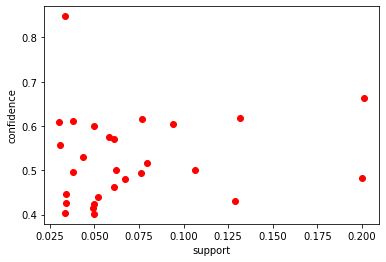

In [276]:
import  matplotlib.pyplot as plt
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],c='r')

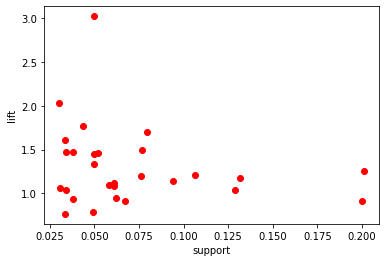

In [277]:
plt.xlabel('support')
plt.ylabel('lift')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.lift[i],c='r')